<a href="https://colab.research.google.com/github/fuyu-quant/Data_Science/blob/main/Data_Science/Computer_Vison/CvT_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional vision Transformer
* [公式](https://github.com/rishikksh20/convolution-vision-transformers)

In [ ]:
! pip install einops

#### Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from pandas_profiling import ProfilieReport
import glob
import pickle
import gc




import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn, einsum
import torch.optim as optim
from einops import rearrange
from einops import repeat
from einops.layers.torch import Rearrange
# from module import ConvAttention, PreNorm, FeedForward
import numpy as np

In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

#### CvTのコード

In [ ]:
class SepConv2d(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 dilation=1,):
        super(SepConv2d, self).__init__()
        self.depthwise = torch.nn.Conv2d(in_channels,
                                         in_channels,
                                         kernel_size=kernel_size,
                                         stride=stride,
                                         padding=padding,
                                         dilation=dilation,
                                         groups=in_channels)
        self.bn = torch.nn.BatchNorm2d(in_channels)
        self.pointwise = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn(x)
        x = self.pointwise(x)
        return x

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class ConvAttention(nn.Module):
    def __init__(self, dim, img_size, heads = 8, dim_head = 64, kernel_size=3, q_stride=1, k_stride=1, v_stride=1, dropout = 0.,
                 last_stage=False):

        super().__init__()
        self.last_stage = last_stage
        self.img_size = img_size
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5
        pad = (kernel_size - q_stride)//2
        self.to_q = SepConv2d(dim, inner_dim, kernel_size, q_stride, pad)
        self.to_k = SepConv2d(dim, inner_dim, kernel_size, k_stride, pad)
        self.to_v = SepConv2d(dim, inner_dim, kernel_size, v_stride, pad)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        if self.last_stage:
            cls_token = x[:, 0]
            x = x[:, 1:]
            cls_token = rearrange(cls_token.unsqueeze(1), 'b n (h d) -> b h n d', h = h)
        x = rearrange(x, 'b (l w) n -> b n l w', l=self.img_size, w=self.img_size)
        q = self.to_q(x)
        q = rearrange(q, 'b (h d) l w -> b h (l w) d', h=h)

        v = self.to_v(x)
        v = rearrange(v, 'b (h d) l w -> b h (l w) d', h=h)

        k = self.to_k(x)
        k = rearrange(k, 'b (h d) l w -> b h (l w) d', h=h)

        if self.last_stage:
            q = torch.cat((cls_token, q), dim=2)
            v = torch.cat((cls_token, v), dim=2)
            k = torch.cat((cls_token, k), dim=2)


        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, img_size, depth, heads, dim_head, mlp_dim, dropout=0., last_stage=False):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, ConvAttention(dim, img_size, heads=heads, dim_head=dim_head, dropout=dropout, last_stage=last_stage)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x




class CvT(nn.Module):
    def __init__(self, image_size, in_channels, num_classes, dim=64, kernels=[7, 3, 3], strides=[4, 2, 2],
                 heads=[1, 3, 6] , depth = [1, 2, 10], pool='cls', dropout=0., emb_dropout=0., scale_dim=4):
        super().__init__()




        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'
        self.pool = pool
        self.dim = dim

        ##### Stage 1 #######
        self.stage1_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[0], strides[0], 2),
            Rearrange('b c h w -> b (h w) c', h = image_size//4, w = image_size//4),
            nn.LayerNorm(dim)
        )
        self.stage1_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//4,depth=depth[0], heads=heads[0], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//4, w = image_size//4)
        )

        ##### Stage 2 #######
        in_channels = dim
        scale = heads[1]//heads[0]
        dim = scale*dim
        self.stage2_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[1], strides[1], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//8, w = image_size//8),
            nn.LayerNorm(dim)
        )
        self.stage2_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//8, depth=depth[1], heads=heads[1], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout),
            Rearrange('b (h w) c -> b c h w', h = image_size//8, w = image_size//8)
        )

        ##### Stage 3 #######
        in_channels = dim
        scale = heads[2] // heads[1]
        dim = scale * dim
        self.stage3_conv_embed = nn.Sequential(
            nn.Conv2d(in_channels, dim, kernels[2], strides[2], 1),
            Rearrange('b c h w -> b (h w) c', h = image_size//16, w = image_size//16),
            nn.LayerNorm(dim)
        )
        self.stage3_transformer = nn.Sequential(
            Transformer(dim=dim, img_size=image_size//16, depth=depth[2], heads=heads[2], dim_head=self.dim,
                                              mlp_dim=dim * scale_dim, dropout=dropout, last_stage=True),
        )


        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout_large = nn.Dropout(emb_dropout)


        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):

        xs = self.stage1_conv_embed(img)
        xs = self.stage1_transformer(xs)

        xs = self.stage2_conv_embed(xs)
        xs = self.stage2_transformer(xs)

        xs = self.stage3_conv_embed(xs)
        b, n, _ = xs.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        xs = torch.cat((cls_tokens, xs), dim=1)
        xs = self.stage3_transformer(xs)
        xs = xs.mean(dim=1) if self.pool == 'mean' else xs[:, 0]

        xs = self.mlp_head(xs)
        return xs


if __name__ == "__main__":
    img = torch.ones([1, 3, 224, 224])

    model = CvT(224, 3, 1000)

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    print('Trainable Parameters: %.3fM' % parameters)

    out = model(img)

    print("Shape of out :", out.shape)  # [B, num_classes]

Trainable Parameters: 20.006M
Shape of out : torch.Size([1, 1000])


#### Configuration

#### 前処理の定義

In [ ]:
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

In [ ]:
# 学習率
lr = 0.01

# バッチサイズ
batch_size = 128

# エポック数
num_epochs = 20

# GPUに載せる
device = torch.device("cuda:0")


# エポック数15，バッチサイズ32で54分
# エポック数15，バッチサイズ128で17分
# エポック数20,バッチサイズ128で23分　精度al_acc: 0.7112342119216919

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# データサイズ，チャネル数，分類数
#model = CvT(32, 3, 10)
model = CNN(10)
device = torch.device("cuda:0")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [ ]:
# 15エポックで54分

losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    # 学習
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)
    
    # 検証
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)
    print("epoch: {}, loss: {}, acc: {}    " \
    "val_epoch: {}, val_loss: {}, val_acc: {}".format(epoch, running_loss, running_acc, epoch, val_running_loss, val_running_acc))

epoch: 0, loss: 1.4438079586419303, acc: 0.47643062472343445    val_epoch: 0, val_loss: 1.1770549673068373, val_acc: 0.5705103278160095
epoch: 1, loss: 0.9751331929660514, acc: 0.6549352407455444    val_epoch: 1, val_loss: 0.9235555295702778, val_acc: 0.6695016026496887
epoch: 2, loss: 0.7677291778042493, acc: 0.7309862375259399    val_epoch: 2, val_loss: 0.782011779803264, val_acc: 0.7260680794715881
epoch: 3, loss: 0.6498440972069646, acc: 0.7749200463294983    val_epoch: 3, val_loss: 0.7255197076857844, val_acc: 0.7525712251663208
epoch: 4, loss: 0.5529793061106406, acc: 0.807684600353241    val_epoch: 4, val_loss: 0.7238148918634728, val_acc: 0.7551424503326416
epoch: 5, loss: 0.47137343365213147, acc: 0.8352741599082947    val_epoch: 5, val_loss: 0.6986233727841438, val_acc: 0.7606803774833679
epoch: 6, loss: 0.40818950693930506, acc: 0.8581840991973877    val_epoch: 6, val_loss: 0.7201601172549815, val_acc: 0.7622627019882202
epoch: 7, loss: 0.3360657981975609, acc: 0.88495045900

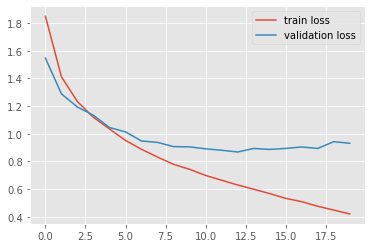

In [ ]:
plt.style.use('ggplot')
plt.plot(losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

TypeError: ignored

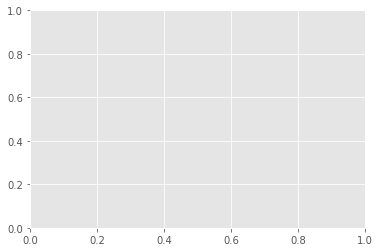

In [ ]:
plt.style.use('ggplot')
plt.plot(accs, label='train acc')
plt.plot(val_accs, label='validation acc')
plt.legend()

#### モデルの利用

In [ ]:
img = torch.ones([1, 3, 224, 224])

model = CvT(224, 3, 1000)

parameters = filter(lambda p: p.requires_grad, model.parameters())
parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
print('Trainable Parameters: %.3fM' % parameters)

out = model(img)

print("Shape of out :", out.shape)  # [B, num_classes]

Trainable Parameters: 20.006M
Shape of out : torch.Size([1, 1000])


In [ ]:
model = CvT(224, 3, 10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

opt = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#### 学習に関する関数の定義

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
  since = time.time()

  #保存するリスト
  loss_history = []
  acc_history = []
  auc_history = []
  val_loss_history = []
  val_acc_history = []
  val_auc_history = []

  #最も精度の良いモデルを保存するリスト
  best_model_weights = copy.deepcopy(model.state_dict())

  #Acuracy値の初期値
  best = 0.0

  #学習の繰り返し
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*60)

    for phase in ['train','val']:
      if phase == 'train':
        #モデルを学習用の状態へ
        model.train()
      else :
        #モデルを評価用の状態へ
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      #dataloaderによる学習および評価の繰り返し
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        

        #勾配の値のリセット
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          #ここは少し謎
          if is_inception and phase == 'train':
            #勾配消失問題を解決するための補助分類機の損失も計算
            outputs, aux_outputs == model(inputs)
            #損失の計算
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4*loss2
          else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

          #予測値(分類値)の出力
          _, preds = torch.max(outputs, 1)

          #誤差の逆伝播とパラメータの更新を行う
          if phase == 'train':
            loss.backward()
            optimizer.step()

        #損失とAccuracyを集計
        #バッチサイズをかけるためにinputs.size(0)で出力している(最後のバッチは同じ大きさだとは限らないため)
        #trainとvalのlossを両方計算に入れて良いのか
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      #損失の計算
      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      #Accuracyの計算
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))


      #Accuracyの保存
      if phase == 'train':
        acc_history.append(epoch_acc)
        loss_history.append(epoch_loss)

#      AUCの保存(二値分類の時用?)
#      labels = labels.cpu().data.numpy()
#      outputs = outputs.cpu().data.numpy()
#      epoch_auc = roc_auc_score(labels, outputs, multi_class='ovr') #マルチクラスの指定
#      auc_history.append(epoch_auc)

      
      #valのAccuracyの保存
      if phase == 'val':
        val_acc_history.append(epoch_acc)
        val_loss_history.append(epoch_loss)


#      valのAUCの保存(二値分類の時用?)
#      labels = labels.cpu().data.numpy()
#      outputs = outputs.cpu().data.numpy()
#      epoch_auc = roc_auc_score(labels, multi_class='ovr') #マルチクラスの指定
#      val_auc_history.append(epoch_auc)



      #モデルの保存
      if phase == 'val' and epoch_acc > best:    #AUCかAccuracyは好きな方に変更する
        best = epoch_acc
        best_model_weight = copy.deepcopy(model.state_dict())



  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Accuracy: {:4f}'.format(best))

  #最も精度の良いモデルを読み込む
  model.load_state_dict(best_model_weights)
  return model, loss_history, acc_history , auc_history, val_loss_history, val_acc_history, val_auc_history
